# Save and read optimization results with netCDF

In [1]:
import os
import sys

import xarray

import FINE as fn
import FINE.IOManagement.xarrayIO as xrIO

import sys

sys.path.append(
    os.path.join(os.getcwd(), "..", "Multi-regional_Energy_System_Workflow")
)
from getData import getData

data = getData()

# 1. Create an energy system model instance
locations = {
    "cluster_0",
    "cluster_1",
    "cluster_2",
    "cluster_3",
    "cluster_4",
    "cluster_5",
    "cluster_6",
    "cluster_7",
}
commodityUnitDict = {
    "electricity": r"GW$_{el}$",
    "methane": r"GW$_{CH_{4},LHV}$",
    "biogas": r"GW$_{biogas,LHV}$",
    "CO2": r"Mio. t$_{CO_2}$/h",
    "hydrogen": r"GW$_{H_{2},LHV}$",
}
commodities = {"electricity", "hydrogen", "methane", "biogas", "CO2"}

esM = fn.EnergySystemModel(
    locations=locations,
    commodities=commodities,
    numberOfTimeSteps=8760,
    commodityUnitsDict=commodityUnitDict,
    hoursPerTimeStep=1,
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0,
)

CO2_reductionTarget = 1


# 2. Add commodity sources to the energy system model
### Wind onshore

esM.add(
    fn.Source(
        esM=esM,
        name="Wind (onshore)",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["Wind (onshore), operationRateMax"],
        capacityMax=data["Wind (onshore), capacityMax"],
        investPerCapacity=1.1,
        opexPerCapacity=1.1 * 0.02,
        interestRate=0.08,
        economicLifetime=20,
    )
)

### PV

esM.add(
    fn.Source(
        esM=esM,
        name="PV",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax=data["PV, operationRateMax"],
        capacityMax=data["PV, capacityMax"],
        investPerCapacity=0.65,
        opexPerCapacity=0.65 * 0.02,
        interestRate=0.08,
        economicLifetime=25,
    )
)


# 3. Add conversion components to the energy system model

### New combined cycly gas turbines for hydrogen
esM.add(
    fn.Conversion(
        esM=esM,
        name="New CCGT plants (hydrogen)",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": 1, "hydrogen": -1 / 0.6},
        hasCapacityVariable=True,
        investPerCapacity=0.7,
        opexPerCapacity=0.021,
        interestRate=0.08,
        economicLifetime=33,
    )
)

### Electrolyzers
esM.add(
    fn.Conversion(
        esM=esM,
        name="Electroylzers",
        physicalUnit=r"GW$_{el}$",
        commodityConversionFactors={"electricity": -1, "hydrogen": 0.7},
        hasCapacityVariable=True,
        investPerCapacity=0.5,
        opexPerCapacity=0.5 * 0.025,
        interestRate=0.08,
        economicLifetime=10,
    )
)


# 4. Add commodity storages to the energy system model

### Lithium ion batteries
esM.add(
    fn.Storage(
        esM=esM,
        name="Li-ion batteries",
        commodity="electricity",
        hasCapacityVariable=True,
        chargeEfficiency=0.95,
        cyclicLifetime=10000,
        dischargeEfficiency=0.95,
        selfDischarge=1 - (1 - 0.03) ** (1 / (30 * 24)),
        chargeRate=1,
        dischargeRate=1,
        doPreciseTsaModeling=False,
        investPerCapacity=0.151,
        opexPerCapacity=0.002,
        interestRate=0.08,
        economicLifetime=22,
    )
)

### Hydrogen filled salt caverns
esM.add(
    fn.Storage(
        esM=esM,
        name="Salt caverns (hydrogen)",
        commodity="hydrogen",
        hasCapacityVariable=True,
        capacityVariableDomain="continuous",
        capacityPerPlantUnit=133,
        chargeRate=1 / 470.37,
        dischargeRate=1 / 470.37,
        sharedPotentialID="Existing salt caverns",
        stateOfChargeMin=0.33,
        stateOfChargeMax=1,
        capacityMax=data["Salt caverns (hydrogen), capacityMax"],
        investPerCapacity=0.00011,
        opexPerCapacity=0.00057,
        interestRate=0.08,
        economicLifetime=30,
    )
)


# 5. Add commodity transmission components to the energy system model

### AC cables
esM.add(
    fn.LinearOptimalPowerFlow(
        esM=esM,
        name="AC cables",
        commodity="electricity",
        hasCapacityVariable=True,
        capacityFix=data["AC cables, capacityFix"],
        reactances=data["AC cables, reactances"],
    )
)

### DC cables
esM.add(
    fn.Transmission(
        esM=esM,
        name="DC cables",
        commodity="electricity",
        losses=data["DC cables, losses"],
        distances=data["DC cables, distances"],
        hasCapacityVariable=True,
        capacityFix=data["DC cables, capacityFix"],
    )
)


### Hydrogen pipelines
esM.add(
    fn.Transmission(
        esM=esM,
        name="Pipelines (hydrogen)",
        commodity="hydrogen",
        distances=data["Pipelines, distances"],
        hasCapacityVariable=True,
        hasIsBuiltBinaryVariable=False,
        bigM=300,
        locationalEligibility=data["Pipelines, eligibility"],
        capacityMax=data["Pipelines, eligibility"] * 15,
        sharedPotentialID="pipelines",
        investPerCapacity=0.000177,
        investIfBuilt=0.00033,
        interestRate=0.08,
        economicLifetime=40,
    )
)

# 6. Add commodity sinks to the energy system model

### Electricity demand
esM.add(
    fn.Sink(
        esM=esM,
        name="Electricity demand",
        commodity="electricity",
        hasCapacityVariable=False,
        operationRateFix=data["Electricity demand, operationRateFix"],
    )
)

## 7.2. Hydrogen sinks
FCEV_penetration = 0.5
esM.add(
    fn.Sink(
        esM=esM,
        name="Hydrogen demand",
        commodity="hydrogen",
        hasCapacityVariable=False,
        operationRateFix=data["Hydrogen demand, operationRateFix"] * FCEV_penetration,
    )
)


esM.aggregateTemporally(numberOfTypicalPeriods=7)
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="OptimalityTol=1e-3 method=2 cuts=0 MIPGap=5e-3",
)

The distances of a component are set to a normalized value of 1.

Clustering time series data with 7 typical periods and 24 time steps per period...


 c:\users\k.knosala\tools\fine\FINE\utils.py:669: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.
 C:\Users\k.knosala\Miniconda3\envs\fine-dev-py36\lib\site-packages\tsam\timeseriesaggregation.py:982: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


		(1.2523 sec)

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3524 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0770 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.1820 sec)

Declaring sets, variables and constraints for LOPFModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3256 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2948 sec)

Declaring shared potential constraint...
		(0.0030 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring com

 c:\users\k.knosala\tools\fine\FINE\storage.py:1170: UserWarning:Charge and discharge at the same time for component Li-ion batteries
 c:\users\k.knosala\tools\fine\FINE\storage.py:1170: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)


for StorageModel ...       (2.4558sec)
for LOPFModel ...          (2.2460sec)
for TransmissionModel ...  (2.5178sec)
		(8.7966 sec)



In [3]:
xr_dss = xrIO.writeOptimizationOutputToNetCDF(
    esM,
    outputFileName="my_esm_results.nc4",
    overwrite_existing=True,
    optSumOutputLevel=2,
    optValOutputLevel=1,
)


Writing output to netCDF... 
	Processing SourceSinkModel ...
	Processing ConversionModel ...
	Processing StorageModel ...
	Processing LOPFModel ...
	Processing TransmissionModel ...
	Saving file...
Done. (1.4711 sec)


In [7]:
xr_dss["SourceSinkModel"]["Wind (onshore)"]

<xarray.Dataset>
Dimensions:                    (space: 8, time: 8760)
Coordinates:
  * space                      (space) <U9 'cluster_0' ... 'cluster_7'
  * time                       (time) int64 0 1 2 3 4 ... 8756 8757 8758 8759
Data variables:
    TAC                        (space) float64 0.0 8.835 3.337 ... 6.028 0.0
    capacity                   (space) float64 0.0 65.92 24.89 ... 44.97 0.0
    capexCap                   (space) float64 0.0 7.385 2.789 ... 5.039 0.0
    invest                     (space) float64 0.0 72.51 27.38 ... 49.47 0.0
    operation                  (space) float64 0.0 1.16e+05 ... 5.23e+04 0.0
    opexCap                    (space) float64 0.0 1.45 0.5477 ... 0.9894 0.0
    operationVariablesOptimum  (time, space) float64 nan 25.43 ... 9.447 nan
    capacityVariablesOptimum   (space) float64 0.0 65.92 24.89 ... 44.97 0.0

In [23]:
xr_dss["SourceSinkModel"]["Wind (onshore)"].drop_dims("time").to_dataframe().T

space,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
TAC,0.0,8.835499,3.336771,10.633329,12.294145,6.768767,6.028313,0.0
capacity,0.0,65.918145,24.894326,79.331044,91.721729,50.499080,44.974846,0.0
capexCap,0.0,7.385299,2.789096,8.888046,10.276267,5.657787,5.038866,0.0
invest,0.0,72.509959,27.383759,87.264148,100.893902,55.548988,49.472331,0.0
operation,0.0,115990.924222,58406.962832,82522.140598,94635.622721,72857.940289,52297.912802,0.0
opexCap,0.0,1.450199,0.547675,1.745283,2.017878,1.110980,0.989447,0.0
capacityVariablesOptimum,0.0,65.918145,24.894326,79.331044,91.721729,50.499080,44.974846,0.0


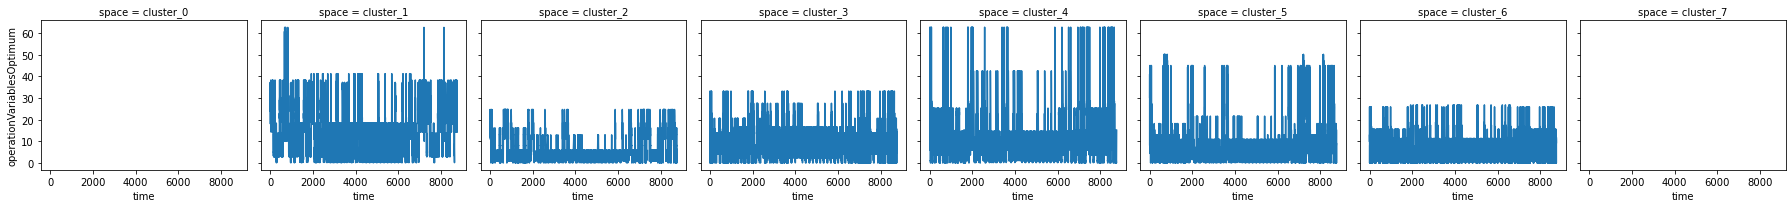

In [27]:
xr_dss["SourceSinkModel"]["Wind (onshore)"]["operationVariablesOptimum"].plot(
    col="space"
)

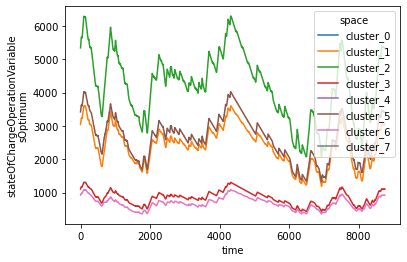

In [37]:
xr_dss["StorageModel"]["Salt caverns (hydrogen)"][
    "stateOfChargeOperationVariablesOptimum"
].plot(hue="space");

In [ ]:
# Read from netCDF file
xr_dss_imported = xrIO.readOptimizationOutputFromNetCDF(
    inputFileName="my_esm_results.nc4"
)